## [Predicting the stock price](https://towardsdatascience.com/in-12-minutes-stocks-analysis-with-pandas-and-scikit-learn-a8d8a7b50ee7)

This jupyter notebook contains notes on how to create a prediction analysis using [sklearn regression models](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning).

Using the [pandas](https://pandas.pydata.org/pandas-docs/version/0.25/install.html) `Dataframe` we can get the nececessary columns from the csv data:

- Adj Close
- Adj Volume
- High Low Percentage (HL PCT)
- PCT Change

In [269]:
"""
Use pandas to read the csv data.
The result is a DataFrame pandas object
"""
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("AAPL.csv")

# Set the dataframe columns
df.columns = ['date', 'open', 'high', 'low', 'close', 'adj_close', 'volume']
# Set date as the index
df.set_index('date', inplace=True)
df.tail()

,open,high,low,close,adj_close,volume
date,,,,,,
2019-09-06,214.050003,214.419998,212.509995,213.259995,213.259995,19362300
2019-09-09,214.839996,216.440002,211.070007,214.169998,214.169998,27309400
2019-09-10,213.860001,216.779999,211.710007,216.699997,216.699997,31777900
2019-09-11,218.070007,223.710007,217.729996,223.589996,223.589996,44289600
2019-09-12,224.800003,226.419998,222.860001,223.089996,223.089996,32036300


In [360]:
close_px = df['adj_close']
mavg = close_px.rolling(window=100).mean()

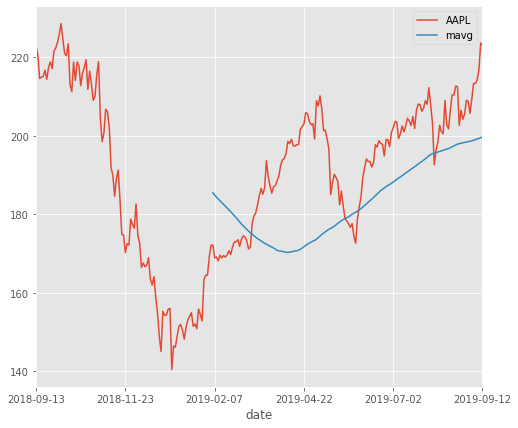

In [362]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='AAPL')
mavg.plot(label='mavg')
plt.legend()

In [363]:
dfreg = df.loc[:, ['adj_close', 'volume']]

# High Low Percentage (HL PCT)
dfreg['HL_PCT'] = (df['high'] - df['low']) / df['close'] * 100.0
# Percent Change
dfreg['PCT_change'] = (df['close'] - df['open']) / df['open'] * 100.0
dfreg.head()

,adj_close,volume,HL_PCT,PCT_change
date,,,,
2018-09-13,222.950317,41706400,2.552890,1.292949
2018-09-14,220.419571,31999300,1.929946,-0.846070
2018-09-17,214.550659,37195100,2.606936,-1.922120
2018-09-18,214.905167,31571700,2.167344,0.206627
2018-09-19,215.033142,27123800,1.978290,-0.059499


In [364]:
import math
import numpy as np
from sklearn import preprocessing, svm
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

# Drop missing value
dfreg.fillna(value=-99999, inplace=True)

# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))

# Separating the label here, we want to predict the AdjClose
forecast_col = 'adj_close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))

# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)

# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]


In [365]:
# Separation of training and testing of model by cross validation train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Building the models

- [Simple Linear Analysis](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression)

- [Quadratic Linear Analysis (QDA)](https://scikit-learn.org/stable/modules/lda_qda.html)

- [K Nearest Neighbor (KNN)](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

In [366]:
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
)    
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [367]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [368]:
# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [369]:
# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [370]:
# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

In [406]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)

print('The linear regression confidence is ', 0.96399641826551985)
print('The quadratic regression 2 confidence is ', 0.96492624557970319)
print('The quadratic regression 3 confidence is ', 0.9652082834532858)
print('The knn regression confidence is ', 0.92844658034790639)

The linear regression confidence is  0.9639964182655198
The quadratic regression 2 confidence is  0.9649262455797032
The quadratic regression 3 confidence is  0.9652082834532858
The knn regression confidence is  0.9284465803479064


Use the score method in each trained model.  The score method finds the mean accuracy of `self.predict(X)` with y of the test data set.

In [407]:
forecast_set = clfreg.predict(X_lately)
dfreg['forecast'] = np.nan

(np.array([ 115.44941187,  115.20206522,  116.78688393,  116.70244946,
        116.58503739,  115.98769407,  116.54315699,  117.40012338,
        117.21473053,  116.57244657,  116.048717  ,  116.26444966,
        115.78374093,  116.50647805,  117.92064806,  118.75581186,
        118.82688731,  119.51873699]), 0.96234891774075604, 18)

(array([115.44941187, 115.20206522, 116.78688393, 116.70244946,
        116.58503739, 115.98769407, 116.54315699, 117.40012338,
        117.21473053, 116.57244657, 116.048717  , 116.26444966,
        115.78374093, 116.50647805, 117.92064806, 118.75581186,
        118.82688731, 119.51873699]), 0.962348917740756, 18)

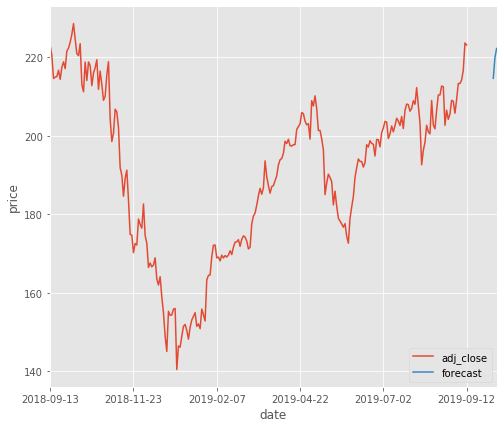

In [408]:
import datetime

last_date = dfreg.iloc[-1].name

last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
    
    
dfreg['adj_close'].tail(500).plot()
dfreg['forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('date')
plt.ylabel('price')
plt.show()